In [ ]:
# ===============
# 1) LOAD DATA
# ===============

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

csv_path = "/content/drive/MyDrive/DS 340W Project/rg30_set1.csv"
df = pd.read_csv(csv_path)

print("Loaded:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: (900, 14)


,n_tasks,n_edges,density,critical_path_len,pct_critical_tasks,T_baseline,mean_m,mean_range_po,instability_m,spi_early,cpi_early,buffer_factor,label_delay,p_late_diag
0,30,28,0.064,2,0.067,20.0,5.467,3.867,3.014,0.765,1.093,1.01,1,0.535
1,30,54,0.124,3,0.100,22.0,5.667,4.067,2.324,0.692,1.069,1.01,1,0.615
2,30,194,0.446,3,0.100,27.0,5.533,3.933,2.315,4.000,1.186,1.01,1,0.610
3,30,43,0.099,6,0.200,26.0,5.167,3.667,2.705,0.654,0.961,1.01,1,0.625
4,30,50,0.115,6,0.200,31.0,5.667,4.067,2.881,0.680,0.973,1.01,0,0.485


In [ ]:
# ======================================================
# 2) PREPROCESSING PIPELINE
#    - Remove leakage & IDs
#    - Handle missing values
#    - Check label distribution
# ======================================================

df_clean = df.copy()

# ---------------------------
# A. Drop leakage features
#    These are variables that give away information not realistically
#    available at prediction time (e.g., diagnostic probabilities or
#    variables computed from future info).
# ---------------------------
leak_cols = [
    "p_late_diag",   # example: probability of lateness from diagnostics
    "buffer_factor", # if constant or derived from outcome
]

# Only drop if they actually exist in the dataframe
to_drop = [c for c in leak_cols if c in df_clean.columns]
df_clean = df_clean.drop(columns=to_drop, errors="ignore")

# ---------------------------
# Also drop ID-like columns (pure identifiers)
# ---------------------------
id_cols = ["proj_id", "file_name"]  # adjust if you have others
to_drop = [c for c in id_cols if c in df_clean.columns]
df_clean = df_clean.drop(columns=to_drop, errors="ignore")

# ---------------------------
# B. Handle missing values
#    For now: drop any rows with NaN in any column.
#    (You could also impute, but this is the simplest clean option.)
# ---------------------------
df_clean = df_clean.dropna().reset_index(drop=True)

# ---------------------------
# C. Inspect the target label
# ---------------------------
print("Label distribution (counts):")
print(df_clean["label_delay"].value_counts())
print("\nLabel distribution (proportions):")
print(df_clean["label_delay"].value_counts(normalize=True))


Label distribution (counts):
label_delay
1    465
0    435
Name: count, dtype: int64

Label distribution (proportions):
label_delay
1    0.516667
0    0.483333
Name: proportion, dtype: float64


In [ ]:
# ======================================================
# 3) TRAIN / VALIDATION / TEST SPLIT (Stratified)
# ======================================================

from sklearn.model_selection import train_test_split

# Features: all columns except the label
X = df_clean.drop(columns=["label_delay"])
# Target: binary label (0 = on time, 1 = delayed)
y = df_clean["label_delay"]

# First split:
#  - Train: 70%
#  - Temp (val + test): 30%
# 'stratify=y' keeps the delay proportion similar in each split.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42  # for reproducibility
)

# Second split:
#  - Validation: 15% of total data (half of temp)
#  - Test: 15% of total data
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Train size:", X_train.shape)
print("Val size:  ", X_val.shape)
print("Test size: ", X_test.shape)


Train size: (630, 11)
Val size:   (135, 11)
Test size:  (135, 11)


In [ ]:
# ======================================================
# 4) FEATURE SCALING (Standardization)
#    - Logistic Regression performs better with scaled inputs
# ======================================================

from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit on TRAIN only, then transform train/val/test.
# This avoids leaking information from val/test into training.
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [ ]:
# ======================================================
# 5) LOGISTIC REGRESSION MODEL
# ======================================================

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Initialize Logistic Regression model
log_reg = LogisticRegression(
    max_iter=500,          # allow more iterations so it converges
    penalty="l2",          # L2 regularization (default)
    solver="lbfgs",        # good general-purpose solver
    class_weight="balanced"  # adjust for any class imbalance
)

# Fit the model on the TRAIN data
log_reg.fit(X_train_scaled, y_train)

# Predict class labels on the VALIDATION set
val_pred = log_reg.predict(X_val_scaled)
# Predict probabilities (for ROC-AUC)
val_proba = log_reg.predict_proba(X_val_scaled)[:, 1]

print("=== VALIDATION PERFORMANCE ===")
print("Accuracy:", round(accuracy_score(y_val, val_pred), 3))
print("F1-score:", round(f1_score(y_val, val_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_val, val_proba), 3))
print("\nClassification Report:")
print(classification_report(y_val, val_pred))


=== VALIDATION PERFORMANCE ===
Accuracy: 0.674
F1-score: 0.686
ROC-AUC: 0.733

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        65
           1       0.69      0.69      0.69        70

    accuracy                           0.67       135
   macro avg       0.67      0.67      0.67       135
weighted avg       0.67      0.67      0.67       135



,feature,coef,abs_coef
7,mean_range_po,-0.875627,0.875627
6,mean_m,0.835541,0.835541
3,critical_path_len,-0.461540,0.461540
4,pct_critical_tasks,-0.452341,0.452341
5,T_baseline,0.296020,0.296020
1,n_edges,0.139668,0.139668
2,density,0.129026,0.129026
8,instability_m,-0.105710,0.105710
9,spi_early,-0.074299,0.074299
10,cpi_early,-0.026634,0.026634


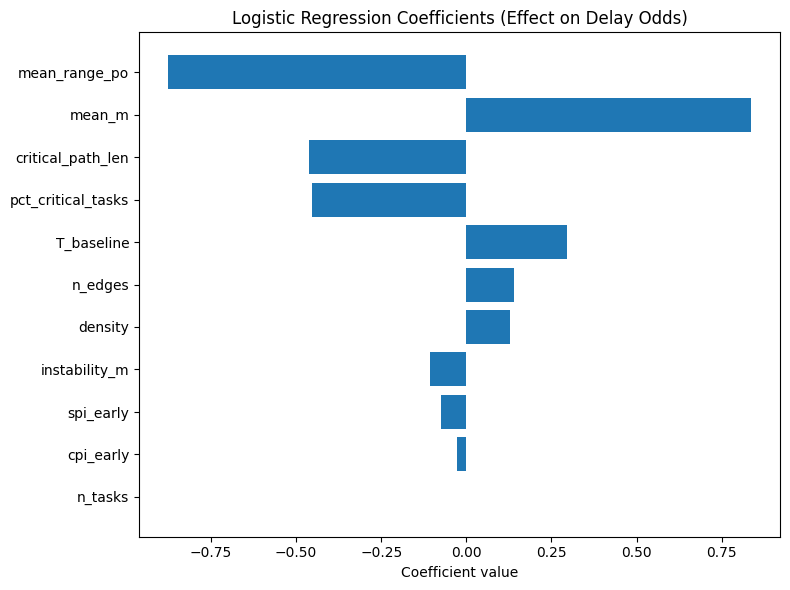

In [ ]:
# ======================================================
# 6) COEFFICIENT ANALYSIS (Interpretability)
# ======================================================

import matplotlib.pyplot as plt

# logistic regression has one coefficient per feature
coef = log_reg.coef_[0]
feature_names = list(X.columns)

# Create a DataFrame to inspect and sort by importance
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

display(coef_df)

# Plot coefficients as a horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.title("Logistic Regression Coefficients (Effect on Delay Odds)")
plt.xlabel("Coefficient value")
plt.gca().invert_yaxis()  # so the largest is on top
plt.tight_layout()
plt.show()


In [ ]:
# ======================================================
# 7) FINAL TEST SET EVALUATION
#    (Do this after you are satisfied with model/params)
# ======================================================

test_pred = log_reg.predict(X_test_scaled)
test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("=== TEST PERFORMANCE ===")
print("Accuracy:", round(accuracy_score(y_test, test_pred), 3))
print("F1-score:", round(f1_score(y_test, test_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba), 3))


=== TEST PERFORMANCE ===
Accuracy: 0.681
F1-score: 0.672
ROC-AUC: 0.757


In [ ]:
test_pred = log_reg.predict(X_test_scaled)
test_proba = log_reg.predict_proba(X_test_scaled)[:,1]

print("TEST RESULTS")
print("Accuracy:", round(accuracy_score(y_test, test_pred),3))
print("F1-score:", round(f1_score(y_test, test_pred),3))
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba),3))


TEST RESULTS
Accuracy: 0.681
F1-score: 0.672
ROC-AUC: 0.757


In [ ]:
# ======================================================
#  NAIVE BAYES MODEL (GaussianNB)
# ======================================================

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

# GaussianNB does NOT require scaling
nb = GaussianNB()

# Fit model
nb.fit(X_train, y_train)

# --- Validation predictions ---
val_pred_nb  = nb.predict(X_val)
val_proba_nb = nb.predict_proba(X_val)[:, 1]

print("\n==============================")
print(" NAIVE BAYES — VALIDATION RESULTS")
print("==============================")
print("Accuracy:", round(accuracy_score(y_val, val_pred_nb), 3))
print("F1-score:", round(f1_score(y_val, val_pred_nb), 3))
print("ROC-AUC:", round(roc_auc_score(y_val, val_proba_nb), 3))
print("\nClassification Report:")
print(classification_report(y_val, val_pred_nb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, val_pred_nb))


# ======================================================
#  FINAL TEST SET EVALUATION
# ======================================================

test_pred_nb  = nb.predict(X_test)
test_proba_nb = nb.predict_proba(X_test)[:, 1]

print("\n==============================")
print(" NAIVE BAYES — TEST RESULTS")
print("==============================")
print("Accuracy:", round(accuracy_score(y_test, test_pred_nb), 3))
print("F1-score:", round(f1_score(y_test, test_pred_nb), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba_nb), 3))
print("\nClassification Report:")
print(classification_report(y_test, test_pred_nb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_pred_nb))



 NAIVE BAYES — VALIDATION RESULTS
Accuracy: 0.652
F1-score: 0.636
ROC-AUC: 0.713

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        65
           1       0.69      0.59      0.64        70

    accuracy                           0.65       135
   macro avg       0.66      0.65      0.65       135
weighted avg       0.66      0.65      0.65       135


Confusion Matrix:
[[47 18]
 [29 41]]

 NAIVE BAYES — TEST RESULTS
Accuracy: 0.681
F1-score: 0.656
ROC-AUC: 0.732

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.70        66
           1       0.73      0.59      0.66        69

    accuracy                           0.68       135
   macro avg       0.69      0.68      0.68       135
weighted avg       0.69      0.68      0.68       135


Confusion Matrix:
[[51 15]
 [28 41]]


 RANDOM FOREST — VALIDATION RESULTS
Accuracy: 0.659
F1-score: 0.671
ROC-AUC: 0.716

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        65
           1       0.67      0.67      0.67        70

    accuracy                           0.66       135
   macro avg       0.66      0.66      0.66       135
weighted avg       0.66      0.66      0.66       135



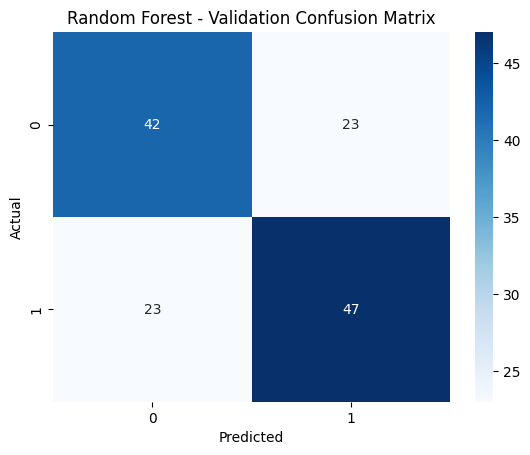


Top Feature Importances:


,feature,importance
10,cpi_early,0.138306
5,T_baseline,0.134488
8,instability_m,0.126248
6,mean_m,0.102499
7,mean_range_po,0.100848
2,density,0.092250
1,n_edges,0.088486
3,critical_path_len,0.076655
4,pct_critical_tasks,0.075640
9,spi_early,0.064580


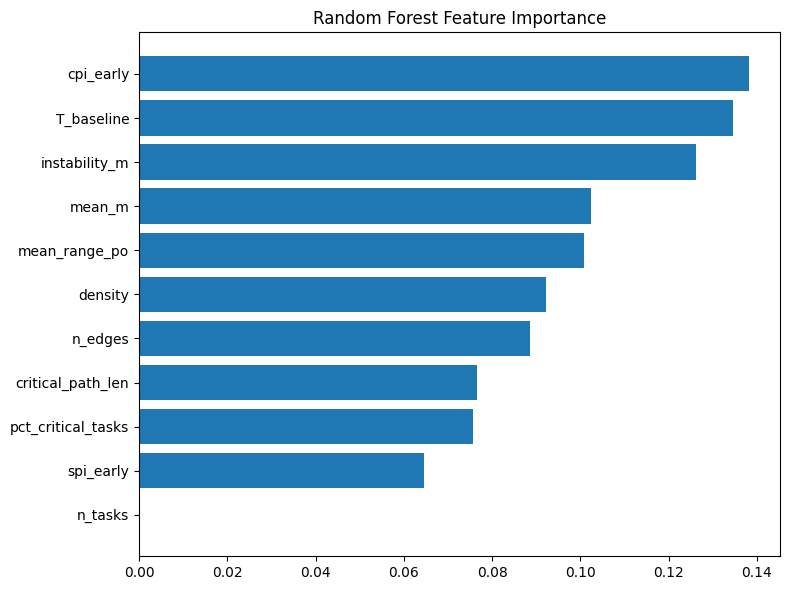

 RANDOM FOREST — TEST RESULTS
Accuracy: 0.711
F1-score: 0.735
ROC-AUC: 0.775

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.64      0.68        66
           1       0.69      0.78      0.73        69

    accuracy                           0.71       135
   macro avg       0.71      0.71      0.71       135
weighted avg       0.71      0.71      0.71       135



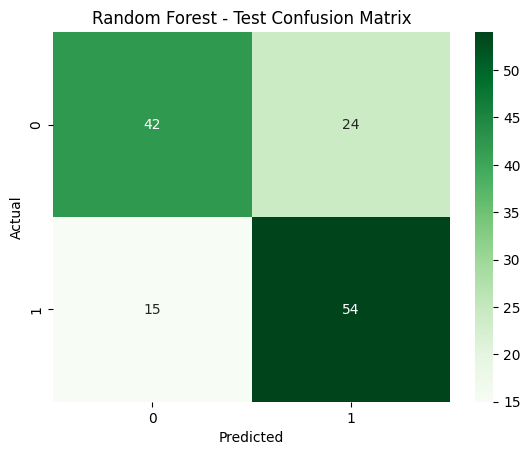

In [ ]:
# ======================================================
# 8) RANDOM FOREST MODEL
# ======================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=300,       # number of trees
    max_depth=None,         # let trees grow fully
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",   # handle slight imbalance
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

# Fit on TRAIN (unscaled)
rf.fit(X_train, y_train)

# Validation predictions
val_pred = rf.predict(X_val)
val_proba = rf.predict_proba(X_val)[:, 1]

print("==============================")
print(" RANDOM FOREST — VALIDATION RESULTS")
print("==============================")
print("Accuracy:", round(accuracy_score(y_val, val_pred), 3))
print("F1-score:", round(f1_score(y_val, val_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_val, val_proba), 3))
print("\nClassification Report:")
print(classification_report(y_val, val_pred))

# Confusion matrix
cm = confusion_matrix(y_val, val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest - Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ======================================================
# 9) FEATURE IMPORTANCE
# ======================================================

importances = rf.feature_importances_
feat_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop Feature Importances:")
display(feat_df)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feat_df["feature"], feat_df["importance"])
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ======================================================
# 10) FINAL TEST SET PERFORMANCE
# ======================================================

test_pred = rf.predict(X_test)
test_proba = rf.predict_proba(X_test)[:, 1]

print("==============================")
print(" RANDOM FOREST — TEST RESULTS")
print("==============================")
print("Accuracy:", round(accuracy_score(y_test, test_pred), 3))
print("F1-score:", round(f1_score(y_test, test_pred), 3))
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba), 3))
print("\nClassification Report:")
print(classification_report(y_test, test_pred))

# Confusion matrix (test)
cm2 = confusion_matrix(y_test, test_pred)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
